# **Análisis de Resultados Saber 11 - Departamento de Caldas**

Este notebook implementa el proceso de selección, limpieza, alistamiento y análisis exploratorio de los datos de las pruebas Saber 11 para el departamento de Caldas, como parte del Proyecto 1 del curso *Analítica Computacional para la Toma de Decisiones*. El producto final está orientado al **Ministerio de Educación** como usuario final, y busca responder tres preguntas de negocio relacionadas con equidad socioeconómica, desempeño territorial y brechas de género.

## Tarea 2 - Selección, limpieza y alistamiento de datos

Los datos provienen del portal de [Datos Abiertos de Colombia](https://www.datos.gov.co/Educaci-n/Resultados-nicos-Saber-11/kgxf-xxbe), actualizados a abril de 2024. Dado que el conjunto original contiene más de 7 millones de filas y 50 columnas (~3.4 GB), se emplearon **AWS Glue** y **AWS Athena** para extraer únicamente el subconjunto correspondiente al departamento de Caldas (≈87,000 filas) con las 26 columnas relevantes para las preguntas de negocio. El subconjunto extraído se carga en Python en el archivo **csv_reader.py**, donde se realizan la limpieza de comillas, el casteo de tipos de datos y la gestión de valores faltantes.

## Tarea 3 - Exploración y análisis de datos

Con los datos limpios y correctamente tipados, se realiza un análisis de datos faltantes antes de continuar con el análisis exploratorio orientado a responder las tres preguntas de negocio en este archivo. Esto incluye estadísticas descriptivas, histogramas, diagramas de caja, diagramas de dispersión y mapas de calor sobre las variables de puntaje, estrato, educación de los padres, municipio, naturaleza del colegio, zona y género.

---

Daniel Benavides - 202220428 - <d.benavidess@uniandes.edu.co>

Juanita Cortés - 202222129 - <jv.cortesv1@uniandes.edu.co>

Andrés Felipe Herrera - 202220888 - <a.herrerat@uniandes.edu.co>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from prettytable import PrettyTable

from matplotlib import font_manager
plt.rcParams['font.family'] = 'Arial'

alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

In [2]:
import warnings
warnings.filterwarnings('ignore')      

## 1. Data loading

In [3]:
df = pd.read_csv('caldas_saber11.csv')

df = df[df['periodo'] > 20141]
df = df.copy()
df.columns

Index(['periodo', 'cole_mcpio_ubicacion', 'cole_depto_ubicacion',
       'punt_matematicas', 'punt_lectura_critica', 'punt_global',
       'fami_estratovivienda', 'fami_educacionmadre', 'fami_educacionpadre',
       'fami_personashogar', 'fami_cuartoshogar', 'fami_tienecomputador',
       'fami_tieneinternet', 'fami_tieneautomovil', 'fami_tienelavadora',
       'punt_c_naturales', 'punt_sociales_ciudadanas', 'punt_ingles',
       'cole_naturaleza', 'cole_area_ubicacion', 'cole_bilingue',
       'estu_genero', 'desemp_ingles'],
      dtype='object')

In [4]:
print(f"Number of rows in the dataset: {len(df)}")

Number of rows in the dataset: 49768


In [5]:
df.head(1)

,periodo,cole_mcpio_ubicacion,cole_depto_ubicacion,punt_matematicas,punt_lectura_critica,punt_global,fami_estratovivienda,fami_educacionmadre,fami_educacionpadre,fami_personashogar,...,fami_tieneautomovil,fami_tienelavadora,punt_c_naturales,punt_sociales_ciudadanas,punt_ingles,cole_naturaleza,cole_area_ubicacion,cole_bilingue,estu_genero,desemp_ingles
0,20224,MANIZALES,CALDAS,43.0,48.0,203.0,NaN,Primaria incompleta,No Aplica,NaN,...,No,Si,37.0,38.0,31.0,OFICIAL,URBANO,NaN,M,A-


In [6]:
categorical_columns = df.select_dtypes(include=['object', 'string']).columns.tolist()
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['cole_mcpio_ubicacion', 'cole_depto_ubicacion', 'fami_estratovivienda', 'fami_educacionmadre', 'fami_educacionpadre', 'fami_personashogar', 'fami_cuartoshogar', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tieneautomovil', 'fami_tienelavadora', 'cole_naturaleza', 'cole_area_ubicacion', 'cole_bilingue', 'estu_genero', 'desemp_ingles']


In [7]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical Columns:", numerical_columns)

Numerical Columns: ['periodo', 'punt_matematicas', 'punt_lectura_critica', 'punt_global', 'punt_c_naturales', 'punt_sociales_ciudadanas', 'punt_ingles']


### 1.1 Data cleaning and transformation

In this section, we will look through every single categorical variable in order to identify the nature of the variable, meaning we will look at its unique values and see if these entries are aligned with what the variable is referring to. If this is not the case, we will clean the columns individually so that only valid values are present in the column, and any other values will either be deleted or transferred to another column in order to facilitate the missing data analysis in **Section 2**.

#### 1.1.1 fami_estratovivienda

In [8]:
fami_estratovivienda = df['fami_estratovivienda'].unique()
print("Unique values in 'fami_estratovivienda':", fami_estratovivienda)

Unique values in 'fami_estratovivienda': [nan 'Estrato 2' 'Estrato 3' 'Estrato 1' 'Estrato 4' 'Estrato 6'
 'Estrato 5' 'Sin Estrato' 'Primaria incompleta' 'Primaria completa'
 'Ninguno' 'Educación profesional completa' 'No sabe'
 'Técnica o tecnológica completa' 'Secundaria (Bachillerato) completa'
 'Secundaria (Bachillerato) incompleta' 'Técnica o tecnológica incompleta']


In [9]:
# Delete rows that do not have valid estrato values
valid_estratos = ['Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6']
df = df[df['fami_estratovivienda'].isin(valid_estratos)]

df['fami_estratovivienda'].unique()

array(['Estrato 2', 'Estrato 3', 'Estrato 1', 'Estrato 4', 'Estrato 6',
       'Estrato 5'], dtype=object)

#### 1.1.2 fami_educacionmadre

In [10]:
fami_educacionmadre = df['fami_educacionmadre'].unique()
print("Unique values in 'educación madre':", fami_educacionmadre)

Unique values in 'educación madre': ['Primaria incompleta' 'Secundaria (Bachillerato) completa'
 'Primaria completa' 'Ninguno' 'Secundaria (Bachillerato) incompleta'
 'No sabe' 'Postgrado' 'Técnica o tecnológica completa'
 'Educación profesional completa' 'Técnica o tecnológica incompleta' nan
 'Educación profesional incompleta' 'No Aplica']


#### 1.1.3 fami_educacionpadre

In [11]:
fami_educacionpadre = df['fami_educacionpadre'].unique()
print("Unique values in 'educación padre':", fami_educacionpadre)

Unique values in 'educación padre': ['Primaria incompleta' nan 'No sabe'
 'Secundaria (Bachillerato) incompleta' 'Ninguno' 'Primaria completa'
 'Secundaria (Bachillerato) completa' 'Educación profesional completa'
 'No Aplica' 'Técnica o tecnológica completa' 'Postgrado'
 'Educación profesional incompleta' 'Técnica o tecnológica incompleta']


#### 1.1.4 fami_personas_hogar

In [12]:
fami_personashogar = df['fami_personashogar'].unique()
print("Unique values in 'fami_personashogar':", fami_personashogar)

Unique values in 'fami_personashogar': ['3 a 4' '1 a 2' '5 a 6' '9 o más' nan '7 a 8' 'Seis' 'Cuatro' 'Siete'
 'Cinco' 'Dos' 'Tres' 'Ocho' 'Una' 'Nueve' 'Doce o más' 'Diez' 'Once']


In [13]:
df['fami_personashogar'] = df['fami_personashogar'].replace({
    '1 a 2': '2',
    '3 a 4': '3',
    '5 a 6': '5',
    '7 a 8': '7',
    '9 o más': '9',
    'Uno': '1',
    'Dos': '2',
    'Tres': '3',
    'Cuatro': '4',
    'Cinco': '5',
    'Seis': '6',
    'Siete': '7',
    'Ocho': '8',
    'Nueve': '9',
    'Diez': '10',
    'Once': '11',
    'Doce o más': '12'
})

# Convert to numeric integer, coercing errors to NaN
df['fami_personashogar'] = pd.to_numeric(df['fami_personashogar'], errors='coerce').astype('Int64')
print("Unique values in 'fami_personashogar' after cleaning:", df['fami_personashogar'].unique())

Unique values in 'fami_personashogar' after cleaning: <IntegerArray>
[3, 2, 5, 9, <NA>, 7, 6, 4, 8, 12, 10, 11]
Length: 12, dtype: Int64


#### 1.1.5 fami_tienecomputador

In [14]:
fami_tienecomputador = df['fami_tienecomputador'].unique()
print("Unique values in 'fami_tienecomputador':", fami_tienecomputador)

Unique values in 'fami_tienecomputador': ['Si' 'No' nan]


In [15]:
# Convert to binary 1/0
df['fami_tienecomputador'] = df['fami_tienecomputador'].replace({
    'Si': 1,
    'No': 0,
    'nan': 0,
}).astype('Int64')

print("Unique values in 'fami_tienecomputador' after cleaning:", df['fami_tienecomputador'].unique())

Unique values in 'fami_tienecomputador' after cleaning: <IntegerArray>
[1, 0, <NA>]
Length: 3, dtype: Int64


#### 1.1.6 fami_tieneinternet

In [16]:
fami_tieneinternet = df['fami_tieneinternet'].unique()
print("Unique values in 'fami_tieneinternet':", fami_tieneinternet)

Unique values in 'fami_tieneinternet': ['Si' 'No' nan]


In [17]:
# Convert to binary 1/0
df['fami_tieneinternet'] = df['fami_tieneinternet'].replace({
    'Si': 1,
    'No': 0,
    'nan': 0,
}).astype('Int64')  

print("Unique values in 'fami_tieneinternet' after cleaning:", df['fami_tieneinternet'].unique())

Unique values in 'fami_tieneinternet' after cleaning: <IntegerArray>
[1, 0, <NA>]
Length: 3, dtype: Int64


#### 1.1.7 fami_tieneautomovil

In [18]:
fami_tieneautomvil = df['fami_tieneautomovil'].unique()
print("Unique values in 'fami_tieneautomovil':", fami_tieneautomvil)

Unique values in 'fami_tieneautomovil': ['No' 'Si' nan]


In [19]:
# Convert to binary 1/0
df['fami_tieneautomovil'] = df['fami_tieneautomovil'].replace({
    'Si': 1,
    'No': 0,
    'nan': 0,
}).astype('Int64')  

print("Unique values in 'fami_tieneautomovil' after cleaning:", df['fami_tieneautomovil'].unique())

Unique values in 'fami_tieneautomovil' after cleaning: <IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64


#### 1.1.8 fami_tienelavadora

In [20]:
fami_tienelavadora = df['fami_tienelavadora'].unique()
print("Unique values in 'fami_tienelavadora':", fami_tienelavadora)

Unique values in 'fami_tienelavadora': ['Si' 'No' nan]


In [21]:
# Convert to binary 1/0
df['fami_tienelavadora'] = df['fami_tienelavadora'].replace({
    'Si': 1,
    'No': 0,
    'nan': 0,
}).astype('Int64')  

print("Unique values in 'fami_tienelavadora' after cleaning:", df['fami_tienelavadora'].unique())

Unique values in 'fami_tienelavadora' after cleaning: <IntegerArray>
[1, 0, <NA>]
Length: 3, dtype: Int64


#### 1.1.9 cole_naturaleza

In [22]:
cole_naturaleza = df['cole_naturaleza'].unique()
print("Unique values in 'cole_naturaleza':", cole_naturaleza)

Unique values in 'cole_naturaleza': ['OFICIAL' 'NO OFICIAL']


In [23]:
df['cole_naturaleza'] = df['cole_naturaleza'].replace({
    'OFICIAL': 'Público',
    'NO OFICIAL': 'Privado',
    'nan': np.nan
})

print("Unique values in 'cole_naturaleza' after cleaning:", df['cole_naturaleza'].unique())


Unique values in 'cole_naturaleza' after cleaning: ['Público' 'Privado']


#### 1.1.10 cole_area_ubicacion

In [24]:
cole_area_ubicacion = df['cole_area_ubicacion'].unique()
print("Unique values in 'cole_area_ubicacion':", cole_area_ubicacion)

Unique values in 'cole_area_ubicacion': ['URBANO' 'RURAL']


#### 1.1.11 cole_bilingue

In [25]:
cole_bilingue = df['cole_bilingue'].unique()
print("Unique values in 'cole_bilingue':", cole_bilingue)

Unique values in 'cole_bilingue': ['N' nan 'S']


In [26]:
df['cole_bilingue'] = df['cole_bilingue'].replace({
    'S': 1,
    'N': 0,
    'nan': 0,
}).astype('Int64')

print("Unique values in 'cole_bilingue' after cleaning:", df['cole_bilingue'].unique())

Unique values in 'cole_bilingue' after cleaning: <IntegerArray>
[0, <NA>, 1]
Length: 3, dtype: Int64


#### 1.1.12 estu_genero

In [27]:
estu_genero = df['estu_genero'].unique()
print("Unique values in 'estu_genero':", estu_genero)

Unique values in 'estu_genero': ['M' 'F' nan]


#### 1.1.13 Replace all nan values with np.nan in the dataframe

In [28]:
df = df.replace('nan', np.nan)

## 2. Missing Data Analysis

In [29]:
# Count percentage of missing values per column
missing_percentages = df.isnull().mean() * 100
missing_table = PrettyTable()
missing_table.field_names = ["Column", "Missing Percentage"]
for column, percentage in missing_percentages.items():
    missing_table.add_row([column, f"{percentage:.2f}%"])
print(missing_table)

+--------------------------+--------------------+
|          Column          | Missing Percentage |
+--------------------------+--------------------+
|         periodo          |       0.00%        |
|   cole_mcpio_ubicacion   |       0.00%        |
|   cole_depto_ubicacion   |       0.00%        |
|     punt_matematicas     |       0.00%        |
|   punt_lectura_critica   |       0.00%        |
|       punt_global        |       0.00%        |
|   fami_estratovivienda   |       0.00%        |
|   fami_educacionmadre    |       0.14%        |
|   fami_educacionpadre    |       0.19%        |
|    fami_personashogar    |       0.87%        |
|    fami_cuartoshogar     |       0.65%        |
|   fami_tienecomputador   |       0.64%        |
|    fami_tieneinternet    |       0.13%        |
|   fami_tieneautomovil    |       0.71%        |
|    fami_tienelavadora    |       0.59%        |
|     punt_c_naturales     |       0.00%        |
| punt_sociales_ciudadanas |       0.00%        |


## 3. Data Analysis

In [30]:
df = df[df['periodo'].between(20142, 20224)]

### 3.1 *¿Cómo varía el desempeño en las pruebas Saber 11 según el estrato socioeconómico y el nivel educativo de los padres en los municipios de Caldas, y qué zonas del departamento concentran las mayores brechas?*

In [31]:
# Index 0-4: sum of household assets
asset_cols = ['fami_tienecomputador', 'fami_tieneinternet', 'fami_tieneautomovil', 'fami_tienelavadora']
df['indice_activos'] = df[asset_cols].sum(axis=1, skipna=True)

estrato_order = ['Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6']

df['fami_estratovivienda'] = pd.Categorical(df['fami_estratovivienda'], categories=estrato_order, ordered=True)

print("Índice de activos creado. Distribución:")
print(df['indice_activos'].value_counts().sort_index())

Índice de activos creado. Distribución:
indice_activos
0     8573
1     8841
2     8525
3    14613
4     7506
Name: count, dtype: Int64


In [ ]:
df_p1 = df.dropna(subset=['fami_estratovivienda', 'punt_global'])
df_p1['fami_estratovivienda'] = df_p1['fami_estratovivienda'].astype(str)

boxplot_estrato = alt.Chart(df_p1).mark_boxplot(extent='min-max', size=40).encode(
    x=alt.X('fami_estratovivienda:O',
            sort=estrato_order,
            title='Estrato socioeconómico',
            axis=alt.Axis(labelAngle=0)),
    y=alt.Y('punt_global:Q', title='Puntaje global', scale=alt.Scale(zero=False)),
    color=alt.Color('fami_estratovivienda:O',
                    sort=estrato_order,
                    legend=None,
                    scale=alt.Scale(scheme='blues'))
).properties(
    width=500,
    height=350,
    title='Distribución del puntaje global por estrato socioeconómico - Caldas'
)

boxplot_estrato

alt.Chart(...)

In [ ]:
edu_order = [
    'Ninguno', 'Primaria incompleta', 'Primaria completa',
    'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa',
    'Técnica o tecnológica incompleta', 'Técnica o tecnológica completa',
    'Educación profesional incompleta', 'Educación profesional completa', 'Postgrado'
]

df_heat = df.dropna(subset=['fami_estratovivienda', 'fami_educacionmadre', 'punt_global'])
df_heat = df_heat[df_heat['fami_educacionmadre'].isin(edu_order)]
df_heat['fami_estratovivienda'] = df_heat['fami_estratovivienda'].astype(str)

heatmap_edu = alt.Chart(df_heat).mark_rect().encode(
    x=alt.X('fami_estratovivienda:O', sort=estrato_order, title='Estrato'),
    y=alt.Y('fami_educacionmadre:O', sort=edu_order, title='Educación de la madre'),
    color=alt.Color('mean(punt_global):Q',
                    title='Puntaje promedio',
                    scale=alt.Scale(scheme='blues'))
).properties(
    width=350,
    height=320,
    title='Puntaje global promedio por estrato y educación de la madre - Caldas'
)

heatmap_edu

alt.Chart(...)

In [ ]:
edu_order = [
    'Ninguno', 'Primaria incompleta', 'Primaria completa',
    'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa',
    'Técnica o tecnológica incompleta', 'Técnica o tecnológica completa',
    'Educación profesional incompleta', 'Educación profesional completa', 'Postgrado'
]

df_heat = df.dropna(subset=['fami_estratovivienda', 'fami_educacionpadre', 'punt_global'])
df_heat = df_heat[df_heat['fami_educacionpadre'].isin(edu_order)]
df_heat['fami_estratovivienda'] = df_heat['fami_estratovivienda'].astype(str)

heatmap_edu = alt.Chart(df_heat).mark_rect().encode(
    x=alt.X('fami_estratovivienda:O', sort=estrato_order, title='Estrato'),
    y=alt.Y('fami_educacionpadre:O', sort=edu_order, title='Educación del padre'),
    color=alt.Color('mean(punt_global):Q',
                    title='Puntaje promedio',
                    scale=alt.Scale(scheme='blues'))
).properties(
    width=350,
    height=320,
    title='Puntaje global promedio por estrato y educación del padre - Caldas'
)

heatmap_edu

alt.Chart(...)

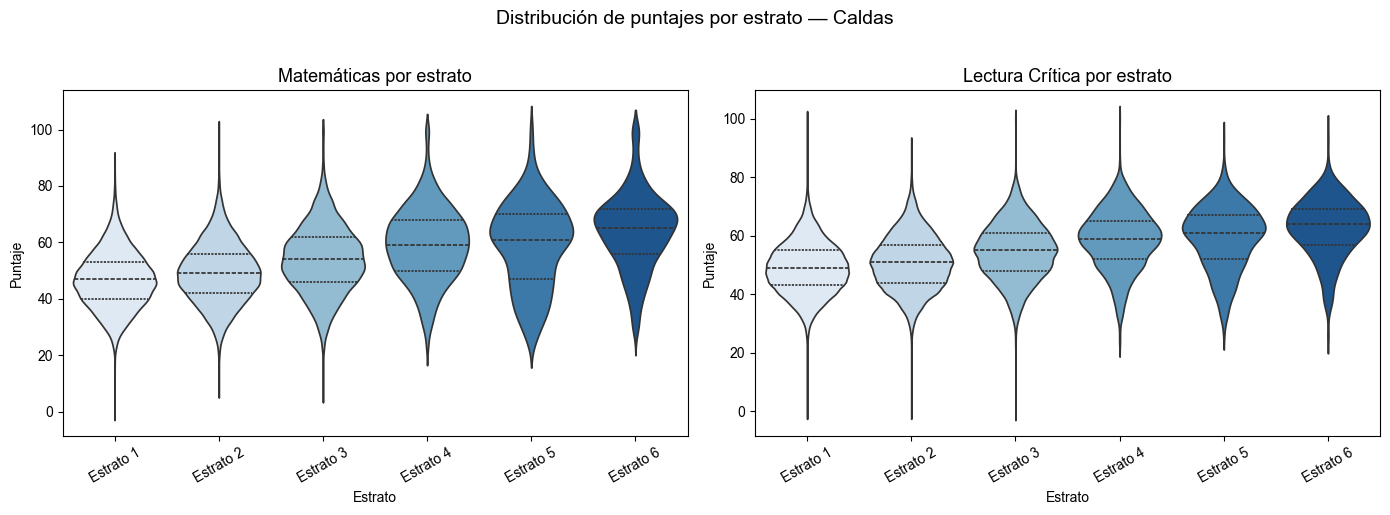

In [ ]:
df_melt = df.dropna(subset=['fami_estratovivienda', 'punt_matematicas', 'punt_lectura_critica'])
df_melt['fami_estratovivienda'] = df_melt['fami_estratovivienda'].astype(str)
df_melt = df_melt.melt(
    id_vars=['fami_estratovivienda'],
    value_vars=['punt_matematicas', 'punt_lectura_critica'],
    var_name='area', value_name='puntaje'
)
df_melt['area'] = df_melt['area'].replace({
    'punt_matematicas': 'Matemáticas',
    'punt_lectura_critica': 'Lectura Crítica'
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
for ax, area in zip(axes, ['Matemáticas', 'Lectura Crítica']):
    data_area = df_melt[df_melt['area'] == area]
    sns.violinplot(
        data=data_area,
        x='fami_estratovivienda', y='puntaje',
        order=estrato_order,
        palette='Blues',
        ax=ax, inner='quartile'
    )
    ax.set_title(f'{area} por estrato', fontsize=13)
    ax.set_xlabel('Estrato')
    ax.set_ylabel('Puntaje')
    ax.tick_params(axis='x', rotation=30)

plt.suptitle('Distribución de puntajes por estrato - Caldas', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
df_activos = df.dropna(subset=['indice_activos', 'punt_global'])
df_activos['indice_activos'] = df_activos['indice_activos'].astype(str)

box_activos = alt.Chart(df_activos).mark_boxplot(extent='min-max', size=50).encode(
    x=alt.X('indice_activos:O',
            title='Índice de activos del hogar (0 = ninguno, 4 = todos)',
            axis=alt.Axis(labelAngle=0)),
    y=alt.Y('punt_global:Q', title='Puntaje global', scale=alt.Scale(zero=False)),
    color=alt.Color('indice_activos:O', legend=None, scale=alt.Scale(scheme='tealblues'))
).properties(
    width=450,
    height=320,
    title='Puntaje global según índice de activos del hogar - Caldas'
)

box_activos

alt.Chart(...)

In [ ]:
estrato_predominante = (
    df.dropna(subset=['fami_estratovivienda'])
    .groupby('cole_mcpio_ubicacion')['fami_estratovivienda']
    .agg(lambda x: x.astype(str).mode()[0])
    .reset_index()
    .rename(columns={'fami_estratovivienda': 'estrato_predominante'})
)

df_mpio = (
    df.groupby('cole_mcpio_ubicacion')['punt_global']
    .mean().reset_index()
    .rename(columns={'punt_global': 'puntaje_promedio'})
    .merge(estrato_predominante, on='cole_mcpio_ubicacion')
    .sort_values('puntaje_promedio', ascending=False)
)

bar_mpio = alt.Chart(df_mpio).mark_bar().encode(
    x=alt.X('puntaje_promedio:Q', title='Puntaje global promedio', scale=alt.Scale(zero=False)),
    y=alt.Y('cole_mcpio_ubicacion:N', sort='-x', title='Municipio'),
    color=alt.Color('estrato_predominante:N',
                    sort=estrato_order,
                    title='Estrato predominante',
                    scale=alt.Scale(scheme='blues')),
    tooltip=['cole_mcpio_ubicacion', 'puntaje_promedio', 'estrato_predominante']
).properties(
    width=450,
    height=500,
    title='Puntaje promedio por municipio y estrato predominante - Caldas'
)

bar_mpio

alt.Chart(...)

### 3.2 *¿Qué municipios de Caldas presentan rendimiento consistentemente bajo, y en qué medida el tipo de colegio (oficial vs. privado) y la zona (rural vs. urbana) explican esas diferencias?*

In [ ]:
df_rank = (
    df.groupby('cole_mcpio_ubicacion')['punt_global']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'puntaje_promedio', 'count': 'n_estudiantes'})
    .sort_values('puntaje_promedio', ascending=False)
)

# Color by above/below median
mediana = df_rank['puntaje_promedio'].median()
df_rank['rendimiento'] = df_rank['puntaje_promedio'].apply(
    lambda x: 'Por encima de la mediana' if x >= mediana else 'Por debajo de la mediana'
)

bar_rank = alt.Chart(df_rank).mark_bar().encode(
    x=alt.X('puntaje_promedio:Q', title='Puntaje global promedio', scale=alt.Scale(zero=False)),
    y=alt.Y('cole_mcpio_ubicacion:N', sort='-x', title='Municipio'),
    color=alt.Color('rendimiento:N',
                    scale=alt.Scale(domain=['Por encima de la mediana', 'Por debajo de la mediana'],
                                    range=['#2196F3', '#EF5350']),
                    title='Rendimiento'),
    tooltip=['cole_mcpio_ubicacion', 'puntaje_promedio', 'n_estudiantes']
).properties(
    width=450,
    height=500,
    title='Ranking de municipios por puntaje global promedio - Caldas'
)

bar_rank

alt.Chart(...)

In [ ]:
df_nat = df.dropna(subset=['cole_naturaleza', 'punt_global'])

box_nat = alt.Chart(df_nat).mark_boxplot(extent='min-max', size=60).encode(
    x=alt.X('cole_naturaleza:N', title='Tipo de colegio', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('punt_global:Q', title='Puntaje global', scale=alt.Scale(zero=False)),
    color=alt.Color('cole_naturaleza:N',
                    scale=alt.Scale(domain=['Público', 'Privado'], range=["#78C1FC", "#42AFF8"]),
                    legend=None)
).properties(
    width=300,
    height=350,
    title='Puntaje global por tipo de colegio - Caldas'
)

box_nat

alt.Chart(...)

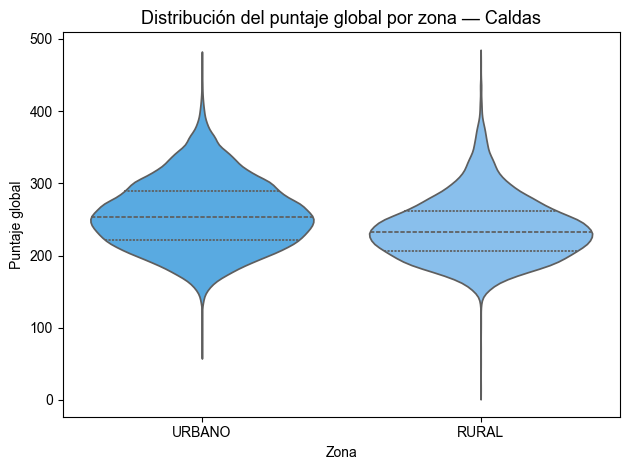

In [ ]:
df_zona = df.dropna(subset=['cole_area_ubicacion', 'punt_global'])

violin_zona = sns.violinplot(
    data=df_zona,
    x='cole_area_ubicacion', y='punt_global',
    palette={'URBANO': '#42AFF8', 'RURAL': '#78C1FC'},
    inner='quartile'
)
plt.title('Distribución del puntaje global por zona - Caldas', fontsize=13)
plt.xlabel('Zona')
plt.ylabel('Puntaje global')
plt.tight_layout()
plt.show()

In [ ]:
df_heat2 = (
    df.dropna(subset=['cole_naturaleza', 'punt_global'])
    .groupby(['cole_mcpio_ubicacion', 'cole_naturaleza'])['punt_global']
    .mean().reset_index()
    .rename(columns={'punt_global': 'puntaje_promedio'})
)

# Sort municipalities by overall average
mpio_order = df_rank.sort_values('puntaje_promedio', ascending=False)['cole_mcpio_ubicacion'].tolist()

heat_nat = alt.Chart(df_heat2).mark_rect().encode(
    x=alt.X('cole_naturaleza:N', title='Tipo de colegio', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('cole_mcpio_ubicacion:N', sort=mpio_order, title='Municipio'),
    color=alt.Color('puntaje_promedio:Q',
                    title='Puntaje promedio',
                    scale=alt.Scale(scheme='blues')),
    tooltip=['cole_mcpio_ubicacion', 'cole_naturaleza', 'puntaje_promedio']
).properties(
    width=200,
    height=500,
    title='Puntaje promedio por municipio y tipo de colegio - Caldas'
)

heat_nat

alt.Chart(...)

In [ ]:
top5 = df_rank.head(5)['cole_mcpio_ubicacion'].tolist()
bot5 = df_rank.tail(5)['cole_mcpio_ubicacion'].tolist()
mpios_sel = top5 + bot5

df_time = (
    df[df['cole_mcpio_ubicacion'].isin(mpios_sel)]
    .groupby(['periodo', 'cole_mcpio_ubicacion'])['punt_global']
    .mean().reset_index()
    .rename(columns={'punt_global': 'puntaje_promedio'})
)
df_time['grupo'] = df_time['cole_mcpio_ubicacion'].apply(
    lambda x: 'Top 5' if x in top5 else 'Bottom 5'
)

line_time = alt.Chart(df_time).mark_line(point=True).encode(
    x=alt.X('periodo:O', title='Período'),
    y=alt.Y('puntaje_promedio:Q', title='Puntaje global promedio', scale=alt.Scale(zero=False)),
    color=alt.Color('cole_mcpio_ubicacion:N', title='Municipio'),
    tooltip=['periodo', 'cole_mcpio_ubicacion', 'puntaje_promedio']
).properties(
    width=550,
    height=350,
    title='Evolución temporal del puntaje - Top 5 y Bottom 5 municipios de Caldas'
)

line_time

alt.Chart(...)

### 3.3 *¿Existen diferencias significativas en los puntajes por género entre matemáticas y lectura crítica en Caldas, y cómo se distribuye esta brecha entre los distintos municipios del departamento?*

In [ ]:
df_gen = df.dropna(subset=['estu_genero'])
df_gen = df_gen[df_gen['estu_genero'].isin(['M', 'F'])]
df_gen['Género'] = df_gen['estu_genero'].map({'M': 'Masculino', 'F': 'Femenino'})

df_gen_melt = df_gen.melt(
    id_vars=['Género'],
    value_vars=['punt_matematicas', 'punt_lectura_critica'],
    var_name='area', value_name='puntaje'
)
df_gen_melt['area'] = df_gen_melt['area'].replace({
    'punt_matematicas': 'Matemáticas',
    'punt_lectura_critica': 'Lectura Crítica'
})

box_gen = alt.Chart(df_gen_melt).mark_boxplot(extent='min-max', size=40).encode(
    x=alt.X('Género:N', title='Género', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('puntaje:Q', title='Puntaje', scale=alt.Scale(zero=False)),
    color=alt.Color('Género:N',
                    scale=alt.Scale(domain=['Masculino', 'Femenino'], range=['#2196F3', '#E91E63']),
                    legend=None),
    column=alt.Column('area:N', title='Área')
).properties(
    width=300,
    height=400,
    title='Puntajes por género y área - Caldas'
)

box_gen

alt.Chart(...)

In [ ]:
# Nueva característica: brecha M - F por municipio
df_brecha = (
    df_gen.groupby(['cole_mcpio_ubicacion', 'Género'])[['punt_matematicas', 'punt_lectura_critica']]
    .mean().reset_index()
)

df_pivot = df_brecha.pivot(index='cole_mcpio_ubicacion', columns='Género',
                            values=['punt_matematicas', 'punt_lectura_critica']).reset_index()
df_pivot.columns = ['municipio', 'lc_f', 'lc_m', 'mat_f', 'mat_m']
df_pivot['brecha_mat'] = df_pivot['mat_m'] - df_pivot['mat_f']
df_pivot['brecha_lc'] = df_pivot['lc_m'] - df_pivot['lc_f']

df_brecha_melt = df_pivot.melt(
    id_vars='municipio',
    value_vars=['brecha_mat', 'brecha_lc'],
    var_name='area', value_name='brecha'
)
df_brecha_melt['area'] = df_brecha_melt['area'].replace({
    'brecha_mat': 'Matemáticas',
    'brecha_lc': 'Lectura Crítica'
})

sort_order_mun = df_pivot.sort_values('brecha_mat', ascending=False)['municipio'].tolist()

bar_brecha = alt.Chart(df_brecha_melt).mark_bar().encode(
    x=alt.X('brecha:Q', title='Brecha (Masculino - Femenino)'),
    y=alt.Y('municipio:N', sort=sort_order_mun, title='Municipio'),
    color=alt.Color('area:N',
                    scale=alt.Scale(domain=['Matemáticas', 'Lectura Crítica'],
                                    range=['#2196F3', '#E91E63']),
                    title='Área'),
    tooltip=['municipio', 'area', 'brecha']
).properties(
    width=400,
    height=500,
    title='Brecha de género por municipio (M - F) - Caldas'
).facet(
    column='area:N'
)

bar_brecha

alt.FacetChart(...)

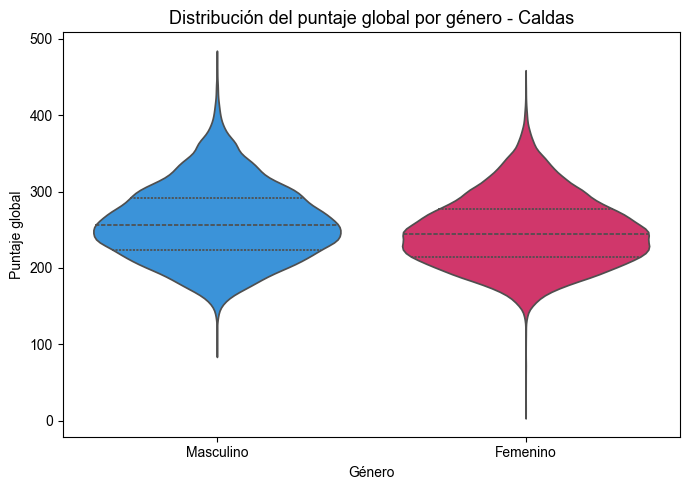

In [60]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.violinplot(
    data=df_gen.dropna(subset=['punt_global']),
    x='Género', y='punt_global',
    palette={'Masculino': '#2196F3', 'Femenino': '#E91E63'},
    inner='quartile', ax=ax
)
ax.set_title('Distribución del puntaje global por género - Caldas', fontsize=13)
ax.set_xlabel('Género')
ax.set_ylabel('Puntaje global')
plt.tight_layout()
plt.show()

In [62]:
ingles_order = ['A-', 'A1', 'A2', 'B1', 'B+']

df_ing = df_gen.dropna(subset=['desemp_ingles', 'punt_global'])
df_ing = df_ing[df_ing['desemp_ingles'].isin(ingles_order)]

heat_gen = alt.Chart(df_ing).mark_rect().encode(
    x=alt.X('Género:N', title='Género', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('desemp_ingles:O', sort=ingles_order, title='Nivel de inglés'),
    color=alt.Color('mean(punt_global):Q',
                    title='Puntaje global promedio',
                    scale=alt.Scale(scheme='purples')),
    tooltip=['Género', 'desemp_ingles', 'mean(punt_global)']
).properties(
    width=250,
    height=250,
    title='Puntaje global promedio por género y nivel de inglés - Caldas'
)

heat_gen

alt.Chart(...)

In [64]:
df_time_gen = (
    df_gen.groupby(['periodo', 'Género'])[['punt_matematicas', 'punt_lectura_critica']]
    .mean().reset_index()
)

df_brecha_time = df_time_gen.pivot(index='periodo', columns='Género',
                                    values=['punt_matematicas', 'punt_lectura_critica']).reset_index()
df_brecha_time.columns = ['periodo', 'lc_f', 'lc_m', 'mat_f', 'mat_m']
df_brecha_time['brecha_mat'] = df_brecha_time['mat_m'] - df_brecha_time['mat_f']
df_brecha_time['brecha_lc'] = df_brecha_time['lc_m'] - df_brecha_time['lc_f']

df_brecha_time_melt = df_brecha_time.melt(
    id_vars='periodo',
    value_vars=['brecha_mat', 'brecha_lc'],
    var_name='area', value_name='brecha'
)
df_brecha_time_melt['area'] = df_brecha_time_melt['area'].replace({
    'brecha_mat': 'Matemáticas',
    'brecha_lc': 'Lectura Crítica'
})

line_brecha = alt.Chart(df_brecha_time_melt).mark_line(point=True).encode(
    x=alt.X('periodo:O', title='Período'),
    y=alt.Y('brecha:Q', title='Brecha (Masculino - Femenino)',
            scale=alt.Scale(zero=True)),
    color=alt.Color('area:N',
                    scale=alt.Scale(domain=['Matemáticas', 'Lectura Crítica'],
                                    range=['#2196F3', '#E91E63']),
                    title='Área'),
    tooltip=['periodo', 'area', 'brecha']
).properties(
    width=550,
    height=320,
    title='Evolución de la brecha de género en matemáticas y lectura crítica - Caldas'
)

# Reference line at 0
ref_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(strokeDash=[4, 4], color='gray').encode(
    y='y:Q'
)

(line_brecha + ref_line)

alt.LayerChart(...)